In [1]:
#notebook to produce figures for information theory of biosignatures paper

In [7]:
from scipy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm.notebook import trange, tqdm

from os import listdir

%matplotlib inline

In [8]:
#change path to location of transit spectral data
#simulations we use are from https://zenodo.org/record/4029370#.Y20OVuzMJhA
path = '/Users/saravannah/Desktop/Dartmouth/Transit_spectra_data/'

resolution = 300 #resolution = deltalambda/lambda

In [9]:
#find index of value in array closest to a given value
#modified from https://www.codegrepper.com/code-examples/python/find+index+of+nearest+value+python
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    
    return idx

#reduce resolution of a spectrum
#takes in array of wavelengths and a specified resolution
def reduce(wave_arr):
    indices = []
    current_wave = wave_arr[0]
    indices.append(0)
    while current_wave < max(wave_arr):
        step_size = current_wave/resolution
        current_wave = current_wave + step_size
        idx = find_nearest(wave_arr, current_wave)
        indices.append(idx)
        
    return indices
    

In [10]:
#This cell is the Djs calculation
def get_djs(spec1):
    
    #spectrum you're comparing to
    #(not modular, but *much* easier for these purposes)
    spec2 = earth

    #compute modal fractions
    p, q = spec1/sum(spec1), spec2/sum(spec2)
    r = 1/2 * (p+q)
    
    Djs = 1/2 * np.sum(p*np.log(p/r)) + 1/2 * np.sum(q*np.log(q/r))
    
    return Djs

In [11]:
#Read and import data
names = listdir(path)

prefix = 'Transit_spectra_FGKM_stars_through_time_'
suffix = '.txt'

#stars in in order from hottest to coldest
stars = ['F0V', 'F7V', 'Sun', 'G8V', 'K2V', 'K7V', 'M1A', 'M3A', 'M8A']
#epochs in data
ages = ['0.0Ga', '0.8Ga', '2.0Ga', '3.9Ga']

In [12]:
#import wavelength array
#all of the simulations have the same wavelength array so can pick whichever you like here
waves = np.loadtxt(path+'Transit_spectra_FGKM_stars_through_time_Sun_3.9Ga.txt', unpack=True, skiprows=1)[0]

#create reduced-resolution wavelength array
#this takes about 5 min
indices = reduce(waves)
waves = np.array([waves[idx] for idx in indices])

In [13]:
#create dictionary to hold data
spectra = {star: [] for star in stars}

#create a dictionary (then data frame) to hold the simulations so that they're easy to iterate thorugh later
#this takes about 13.5 min for our data with resolution of 300 - be patient
for i in trange(len(stars), desc='Loop through stars'):
    star = stars[i]
    star_spectra = []
    #for age in ages:
    for j in trange(len(ages), desc='Loop through ages'):
        age = ages[j]
        
        #load data into dictionary
        spectrum = np.loadtxt(path+prefix+star+'_'+age+suffix, unpack=True, skiprows=1)[1]
        spectrum = [spectrum[idx] for idx in indices]
        star_spectra.append(spectrum)
    spectra[star] = star_spectra
    
#changing data structures
spectra_df = pd.DataFrame(spectra, index=ages)

Loop through stars:   0%|          | 0/9 [00:00<?, ?it/s]

Loop through ages:   0%|          | 0/4 [00:00<?, ?it/s]

Loop through ages:   0%|          | 0/4 [00:00<?, ?it/s]

Loop through ages:   0%|          | 0/4 [00:00<?, ?it/s]

Loop through ages:   0%|          | 0/4 [00:00<?, ?it/s]

Loop through ages:   0%|          | 0/4 [00:00<?, ?it/s]

Loop through ages:   0%|          | 0/4 [00:00<?, ?it/s]

Loop through ages:   0%|          | 0/4 [00:00<?, ?it/s]

Loop through ages:   0%|          | 0/4 [00:00<?, ?it/s]

Loop through ages:   0%|          | 0/4 [00:00<?, ?it/s]

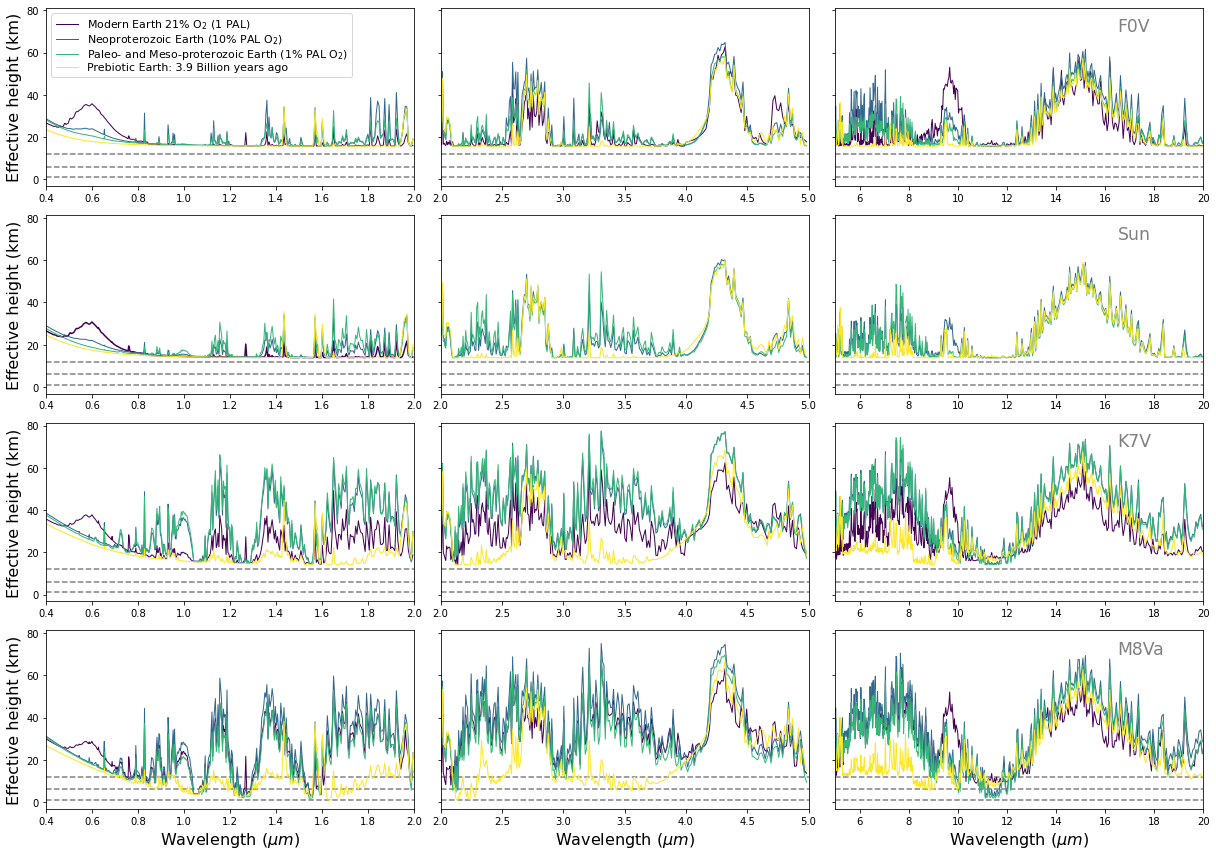

In [14]:
#to match Kaltengegger fig 2 -
#3x4 subplots. Cols split wavelength to be linear but different scales - [0.4, 2.0], [2.0, 5.0], [5,20]
#Rows split into 4 different stars - F0V, Sun, K7V, M8V
#each plot containes all 4 planetary ages
fig, axs = plt.subplots(4, 3, sharey=True, tight_layout=True)

for x in range(4):
    axs[x,0].set_xlim([0.4,2.0])
    axs[x,1].set_xlim([2.0,5.0])
    axs[x,2].set_xlim([5.0,20.0])
        
indices1 = [0,find_nearest(waves, 2.0)]
indices2 = [find_nearest(waves, 2.0), find_nearest(waves, 5.0)]
indices3 = [find_nearest(waves, 5.0), find_nearest(waves, 20.0)]
  


axs[0,2].text(16.5,70,'F0V', fontsize='xx-large', c='gray')
axs[1,2].text(16.5,70,'Sun', fontsize='xx-large', c='gray')
axs[2,2].text(16.5,70,'K7V', fontsize='xx-large', c='gray')
axs[3,2].text(16.5,70,'M8Va', fontsize='xx-large', c='gray')

axs[3,0].set_xlabel(r'Wavelength ($\mu m$)', fontsize='16')
axs[3,1].set_xlabel(r'Wavelength ($\mu m$)', fontsize='16')
axs[3,2].set_xlabel(r'Wavelength ($\mu m$)', fontsize='16')

axs[0,0].set_ylabel('Effective height (km)', fontsize='16')
axs[1,0].set_ylabel('Effective height (km)', fontsize='16')
axs[2,0].set_ylabel('Effective height (km)', fontsize='16')
axs[3,0].set_ylabel('Effective height (km)', fontsize='16')

plt.gcf().set_size_inches(17, 12)



#cloud heights to match Kaltenegger 2020
for ax in axs.flat:
    ax.axhline(1, 0,20, linestyle='dashed', c='gray')
    ax.axhline(6, 0,20, linestyle='dashed', c='gray')
    ax.axhline(12, 0,20, linestyle='dashed', c='gray')

#========================================================================================
#                  First col (wavelengths from 0.4 to 2.0)
#=========================================================================================

axs[0,0].plot(waves[indices1[0]:indices1[1]], spectra_df['F0V']['0.0Ga'][indices1[0]:indices1[1]], color='#440154', label=r'Modern Earth 21% O$_2$ (1 PAL)', linewidth=1)
axs[0,0].plot(waves[indices1[0]:indices1[1]], spectra_df['F0V']['0.8Ga'][indices1[0]:indices1[1]], color='#31688e', label=r'Neoproterozoic Earth (10% PAL O$_2$)', linewidth=1)
axs[0,0].plot(waves[indices1[0]:indices1[1]], spectra_df['F0V']['2.0Ga'][indices1[0]:indices1[1]], color='#35b779', label=r'Paleo- and Meso-proterozoic Earth (1% PAL O$_2$)', linewidth=1)
axs[0,0].plot(waves[indices1[0]:indices1[1]], spectra_df['F0V']['3.9Ga'][indices1[0]:indices1[1]], color='#fde725', label='Prebiotic Earth: 3.9 Billion years ago', linewidth=1) 

axs[0,0].legend(loc='upper left', frameon='False', fontsize=11, facecolor='None', labelspacing=0.1)

axs[1,0].plot(waves[indices1[0]:indices1[1]], spectra_df['Sun']['0.0Ga'][indices1[0]:indices1[1]], color='#440154', label='Modern Earth 21% O2 (1 PAL)')
axs[1,0].plot(waves[indices1[0]:indices1[1]], spectra_df['Sun']['0.8Ga'][indices1[0]:indices1[1]], color='#31688e', linewidth=1)
axs[1,0].plot(waves[indices1[0]:indices1[1]], spectra_df['Sun']['2.0Ga'][indices1[0]:indices1[1]], color='#35b779', linewidth=1)
axs[1,0].plot(waves[indices1[0]:indices1[1]], spectra_df['Sun']['3.9Ga'][indices1[0]:indices1[1]], color='#fde725', linewidth=1)   

axs[2,0].plot(waves[indices1[0]:indices1[1]], spectra_df['K7V']['0.0Ga'][indices1[0]:indices1[1]], color='#440154', linewidth=1)
axs[2,0].plot(waves[indices1[0]:indices1[1]], spectra_df['K7V']['0.8Ga'][indices1[0]:indices1[1]], color='#31688e', linewidth=1)
axs[2,0].plot(waves[indices1[0]:indices1[1]], spectra_df['K7V']['2.0Ga'][indices1[0]:indices1[1]], color='#35b779', linewidth=1)
axs[2,0].plot(waves[indices1[0]:indices1[1]], spectra_df['K7V']['3.9Ga'][indices1[0]:indices1[1]], color='#fde725', linewidth=1)

axs[3,0].plot(waves[indices1[0]:indices1[1]], spectra_df['M8A']['0.0Ga'][indices1[0]:indices1[1]], color='#440154', linewidth=1)
axs[3,0].plot(waves[indices1[0]:indices1[1]], spectra_df['M8A']['0.8Ga'][indices1[0]:indices1[1]], color='#31688e', linewidth=1)
axs[3,0].plot(waves[indices1[0]:indices1[1]], spectra_df['M8A']['2.0Ga'][indices1[0]:indices1[1]], color='#35b779', linewidth=1)
axs[3,0].plot(waves[indices1[0]:indices1[1]], spectra_df['M8A']['3.9Ga'][indices1[0]:indices1[1]], color='#fde725', linewidth=1)

#========================================================================================
#                  Second col (wavelengths from 2.0 to 5.0)
#=========================================================================================
axs[0,1].plot(waves[indices2[0]:indices2[1]], spectra_df['F0V']['0.0Ga'][indices2[0]:indices2[1]], color='#440154', linewidth=1)
axs[0,1].plot(waves[indices2[0]:indices2[1]], spectra_df['F0V']['0.8Ga'][indices2[0]:indices2[1]], color='#31688e', linewidth=1)
axs[0,1].plot(waves[indices2[0]:indices2[1]], spectra_df['F0V']['2.0Ga'][indices2[0]:indices2[1]], color='#35b779', linewidth=1)
axs[0,1].plot(waves[indices2[0]:indices2[1]], spectra_df['F0V']['3.9Ga'][indices2[0]:indices2[1]], color='#fde725', linewidth=1)

axs[1,1].plot(waves[indices2[0]:indices2[1]], spectra_df['Sun']['0.8Ga'][indices2[0]:indices2[1]], color='#31688e', linewidth=1)
axs[1,1].plot(waves[indices2[0]:indices2[1]], spectra_df['Sun']['2.0Ga'][indices2[0]:indices2[1]], color='#35b779', linewidth=1)
axs[1,1].plot(waves[indices2[0]:indices2[1]], spectra_df['Sun']['3.9Ga'][indices2[0]:indices2[1]], color='#fde725', linewidth=1)   


axs[2,1].plot(waves[indices2[0]:indices2[1]], spectra_df['K7V']['0.0Ga'][indices2[0]:indices2[1]], color='#440154', linewidth=1)
axs[2,1].plot(waves[indices2[0]:indices2[1]], spectra_df['K7V']['0.8Ga'][indices2[0]:indices2[1]], color='#31688e', linewidth=1)
axs[2,1].plot(waves[indices2[0]:indices2[1]], spectra_df['K7V']['2.0Ga'][indices2[0]:indices2[1]], color='#35b779', linewidth=1)
axs[2,1].plot(waves[indices2[0]:indices2[1]], spectra_df['K7V']['3.9Ga'][indices2[0]:indices2[1]], color='#fde725', linewidth=1)

axs[3,1].plot(waves[indices2[0]:indices2[1]], spectra_df['M8A']['0.0Ga'][indices2[0]:indices2[1]], color='#440154', linewidth=1)
axs[3,1].plot(waves[indices2[0]:indices2[1]], spectra_df['M8A']['0.8Ga'][indices2[0]:indices2[1]], color='#31688e', linewidth=1)
axs[3,1].plot(waves[indices2[0]:indices2[1]], spectra_df['M8A']['2.0Ga'][indices2[0]:indices2[1]], color='#35b779', linewidth=1)
axs[3,1].plot(waves[indices2[0]:indices2[1]], spectra_df['M8A']['3.9Ga'][indices2[0]:indices2[1]], color='#fde725', linewidth=1)

#========================================================================================
#                  Third col (wavelengths from 5.0 to 20.0)
#=========================================================================================
axs[0,2].plot(waves[indices3[0]:indices3[1]], spectra_df['F0V']['0.0Ga'][indices3[0]:indices3[1]], color='#440154', linewidth=1)
axs[0,2].plot(waves[indices3[0]:indices3[1]], spectra_df['F0V']['0.8Ga'][indices3[0]:indices3[1]], color='#31688e', linewidth=1)
axs[0,2].plot(waves[indices3[0]:indices3[1]], spectra_df['F0V']['2.0Ga'][indices3[0]:indices3[1]], color='#35b779', linewidth=1)
axs[0,2].plot(waves[indices3[0]:indices3[1]], spectra_df['F0V']['3.9Ga'][indices3[0]:indices3[1]], color='#fde725', linewidth=1)

axs[1,2].plot(waves[indices3[0]:indices3[1]], spectra_df['Sun']['0.8Ga'][indices3[0]:indices3[1]], color='#31688e', linewidth=1)
axs[1,2].plot(waves[indices3[0]:indices3[1]], spectra_df['Sun']['2.0Ga'][indices3[0]:indices3[1]], color='#35b779', linewidth=1)
axs[1,2].plot(waves[indices3[0]:indices3[1]], spectra_df['Sun']['3.9Ga'][indices3[0]:indices3[1]], color='#fde725', linewidth=1)   

axs[2,2].plot(waves[indices3[0]:indices3[1]], spectra_df['K7V']['0.0Ga'][indices3[0]:indices3[1]], color='#440154', linewidth=1)
axs[2,2].plot(waves[indices3[0]:indices3[1]], spectra_df['K7V']['0.8Ga'][indices3[0]:indices3[1]], color='#31688e', linewidth=1)
axs[2,2].plot(waves[indices3[0]:indices3[1]], spectra_df['K7V']['2.0Ga'][indices3[0]:indices3[1]], color='#35b779', linewidth=1)
axs[2,2].plot(waves[indices3[0]:indices3[1]], spectra_df['K7V']['3.9Ga'][indices3[0]:indices3[1]], color='#fde725', linewidth=1)
    
axs[3,2].plot(waves[indices3[0]:indices3[1]], spectra_df['M8A']['0.0Ga'][indices3[0]:indices3[1]], color='#440154', linewidth=1)
axs[3,2].plot(waves[indices3[0]:indices3[1]], spectra_df['M8A']['0.8Ga'][indices3[0]:indices3[1]], color='#31688e', linewidth=1)
axs[3,2].plot(waves[indices3[0]:indices3[1]], spectra_df['M8A']['2.0Ga'][indices3[0]:indices3[1]], color='#35b779', linewidth=1)
axs[3,2].plot(waves[indices3[0]:indices3[1]], spectra_df['M8A']['3.9Ga'][indices3[0]:indices3[1]], color='#fde725', linewidth=1)


plt.savefig('raw_spectra.png')

In [15]:
#calculating Djs compared to Earth for each planet
earth = spectra_df['Sun']['0.0Ga']
djs_df = spectra_df.applymap(lambda spec: get_djs(spec))

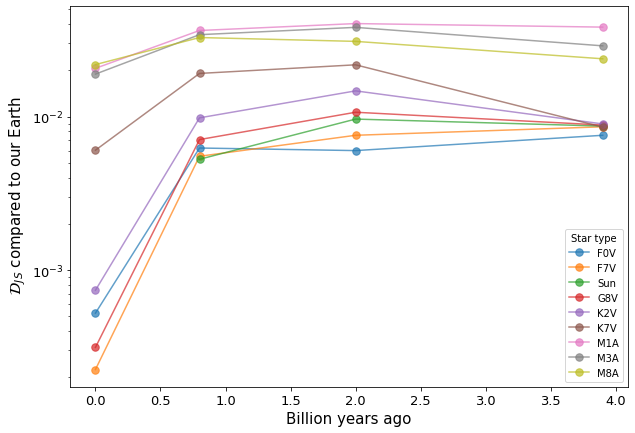

In [16]:
#compute the Djs for each planet relative to our modern Earth 

years = [0, 0.8, 2, 3.9]
plt.plot(years, djs_df['F0V'], label='F0V', marker='.', markersize=15, alpha=0.7)
plt.plot(years, djs_df['F7V'], label='F7V', marker='.', markersize=15, alpha=0.7)
plt.plot(years[1:], djs_df['Sun'][1:], label='Sun', marker='.', markersize=15, alpha=0.7)
plt.plot(years, djs_df['G8V'], label='G8V', marker='.', markersize=15, alpha=0.7)
plt.plot(years, djs_df['K2V'], label='K2V', marker='.', markersize=15, alpha=0.7)
plt.plot(years, djs_df['K7V'], label='K7V', marker='.', markersize=15, alpha=0.7)
plt.plot(years, djs_df['M1A'], label='M1A', marker='.', markersize=15, alpha=0.7)
plt.plot(years, djs_df['M3A'], label='M3A', marker='.', markersize=15, alpha=0.7)
plt.plot(years, djs_df['M8A'], label='M8A', marker='.', markersize=15, alpha=0.7)

plt.xlabel('Billion years ago', fontsize=15)
plt.ylabel(r' $\mathcal{D}_{JS}$ compared to our Earth', fontsize=15)

plt.yscale('log')
plt.legend(title='Star type', fontsize=10)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.gcf().set_size_inches(10, 7)

#plt.savefig('earth_through_the_ages.png')

In [17]:
#calculate Djs *density*
#this is identical to the get_djs() method above but without the sum 
def get_djs_density(spec1):
    
    spec2 = earth
    p, q = spec1/sum(spec1), spec2/sum(spec2)
    r = 1/2 * (p+q)
    
    Djs_dens = 1/2 * p*np.log(p/r) + 1/2 * q*np.log(q/r)
    
    return Djs_dens

In [18]:
#this plots absorption line (here, at wavenumber locations) labels onto a specified axis
#to use this, you'll need to specify a height on the plot you want to plot every label at
#may be easier to do this by hand depending on how you're using the program
def add_line_labels(axis, height, wavelength=False):
    
    if wavelength:
        strong_CO2 = np.array([1.6, 2.1, 2.8, 3.0, 4.4, 4.8, 5.5, 10.5, 15])
        strong_O2 = np.array([0.7])
        strong_O3 = np.array([0.6, 10])
        strong_CH4 = np.array([1.0,1.2,1.4,1.7, 2.3, 3.4, 7.5])
        strong_H2O = np.array([2.7, 3.8, 6, 18.5])
        strong_N2O = np.array([16.5])
    else: 
        #absorption line locations (in inverse um)
        strong_CO2 = 2*np.pi/np.array([1.6, 2.1, 2.8, 3.0, 4.4, 4.8, 5.5, 10.5, 15])
        strong_O2 = 2*np.pi/np.array([0.7])
        strong_O3 = 2*np.pi/np.array([0.6, 10])
        strong_CH4 = 2*np.pi/np.array([1.0,1.2,1.4,1.7, 2.3, 3.4, 7.5])
        strong_H2O = 2*np.pi/np.array([2.7, 3.8, 6, 18.5])
        strong_N2O = 2*np.pi/np.array([16.5])
    


    #plot absorption line (here, wavenumber) labels
    for i in range(len(strong_CO2)):
        #axis.axvline(x=strong_CO2[i], ymin = 0.7, ymax=0.9, color='black')
        axis.text(strong_CO2[i], height, 'CO2', fontsize='small')
    for i in range(len(strong_O2)):
        #axis.axvline(x=strong_O2[i], ymin = 0.7, ymax=0.9, color='red')
        axis.text(strong_O2[i], height, 'O2', fontsize='small')
    for i in range(len(strong_O3)):
        #axis.axvline(x=strong_O3[i], ymin = 0.7, ymax=0.9, color='blue')
        axis.text(strong_O3[i], height, 'O3', fontsize='small')
    for i in range(len(strong_CH4)):
        #axis.axvline(x=strong_CH4[i], ymin = 0.7, ymax=0.9, color='blue')
        axis.text(strong_CH4[i], height, 'CH4', fontsize='small')
    for i in range(len(strong_H2O)):
        #axis.axvline(x=strong_CH4[i], ymin = 0.7, ymax=0.9, color='blue')
        axis.text(strong_H2O[i], height, 'H2O', fontsize='small')
    for i in range(len(strong_N2O)):
        #axis.axvline(x=strong_CH4[i], ymin = 0.7, ymax=0.9, color='blue')
        axis.text(strong_N2O[i], height, 'N2O', fontsize='small')
        


In [19]:
#this calculates the Djs denity of every spectrum in our dataset (about different stars & through different ages)
djs_dens_df = spectra_df.applymap(lambda spec: get_djs_density(spec))

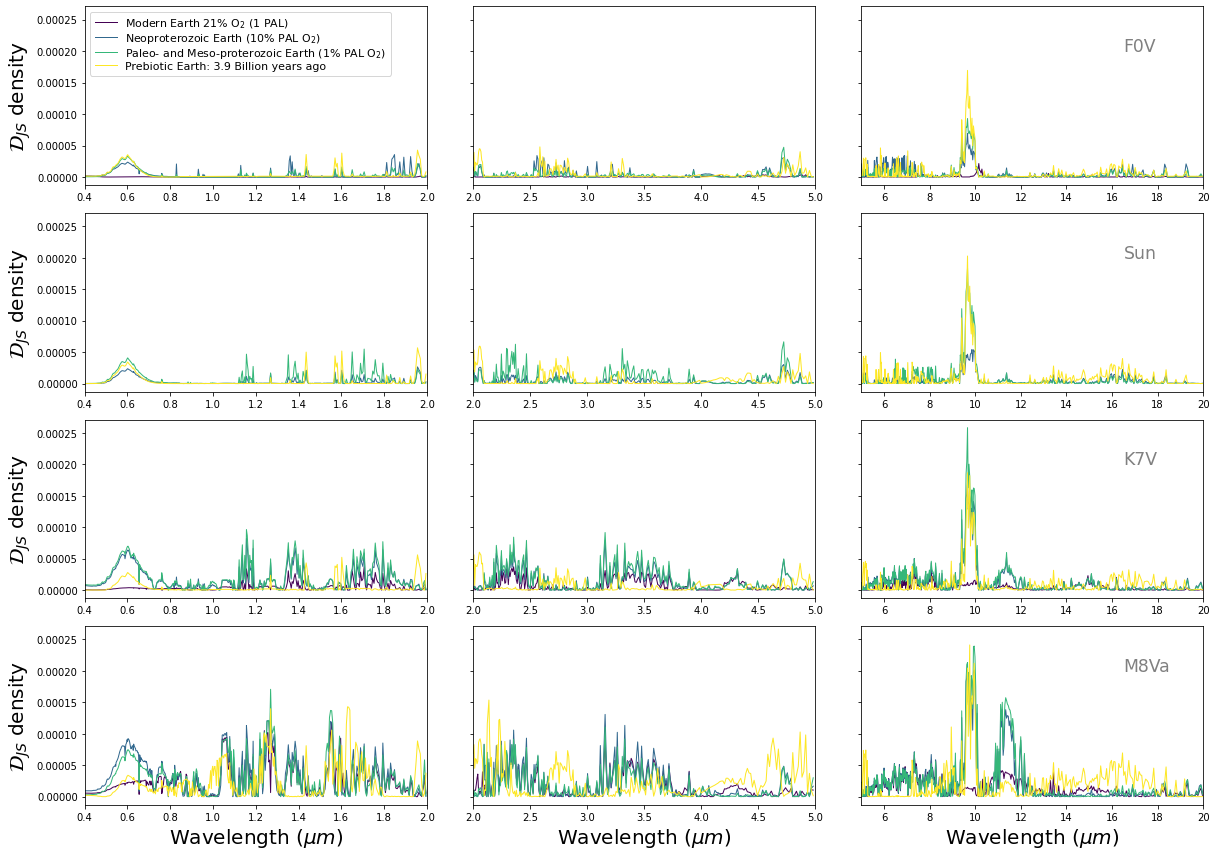

In [20]:
#to match Kaltengegger fig 2 -
#3x4 subplots. Cols split wavelength to be linear but different scales - [0.4, 2.0], [2.0, 5.0], [5,20]
#Rows split into 4 different stars - F0V, Sun, K7V, M8V
#each plot containes all 4 planetary ages
fig, axs = plt.subplots(4, 3, sharey=True, tight_layout=True)

for x in range(4):
    axs[x,0].set_xlim([0.4,2.0])
    axs[x,1].set_xlim([2.0,5.0])
    axs[x,2].set_xlim([5.0,20.0])
    
#for y in range(3):
#    axs[0,y].set_yscale(['log'])
#plt.yscale('log')
        
indices1 = [0,find_nearest(waves, 2.0)]
indices2 = [find_nearest(waves, 2.0), find_nearest(waves, 5.0)]
indices3 = [find_nearest(waves, 5.0), find_nearest(waves, 20.0)]
  


axs[0,2].text(16.5,2e-4,'F0V', fontsize='xx-large', c='gray')
axs[1,2].text(16.5,2e-4,'Sun', fontsize='xx-large', c='gray')
axs[2,2].text(16.5,2e-4,'K7V', fontsize='xx-large', c='gray')
axs[3,2].text(16.5,2e-4,'M8Va', fontsize='xx-large', c='gray')

axs[3,0].set_xlabel(r'Wavelength ($\mu m$)', fontsize='20')
axs[3,1].set_xlabel(r'Wavelength ($\mu m$)', fontsize='20')
axs[3,2].set_xlabel(r'Wavelength ($\mu m$)', fontsize='20')

axs[0,0].set_ylabel(r'$\mathcal{D}_{JS}$ density', fontsize='20')
axs[1,0].set_ylabel(r'$\mathcal{D}_{JS}$ density', fontsize='20')
axs[2,0].set_ylabel(r'$\mathcal{D}_{JS}$ density', fontsize='20')
axs[3,0].set_ylabel(r'$\mathcal{D}_{JS}$ density', fontsize='20')

plt.gcf().set_size_inches(17, 12)


#========================================================================================
#                  First col (wavelengths from 0.4 to 2.0)
#=========================================================================================

axs[0,0].plot(waves[indices1[0]:indices1[1]], djs_dens_df['F0V']['0.0Ga'][indices1[0]:indices1[1]], color='#440154', label=r'Modern Earth 21% O$_2$ (1 PAL)', linewidth=1)
axs[0,0].plot(waves[indices1[0]:indices1[1]], djs_dens_df['F0V']['0.8Ga'][indices1[0]:indices1[1]], color='#31688e', label=r'Neoproterozoic Earth (10% PAL O$_2$)', linewidth=1)
axs[0,0].plot(waves[indices1[0]:indices1[1]], djs_dens_df['F0V']['2.0Ga'][indices1[0]:indices1[1]], color='#35b779', label=r'Paleo- and Meso-proterozoic Earth (1% PAL O$_2$)', linewidth=1)
axs[0,0].plot(waves[indices1[0]:indices1[1]], djs_dens_df['F0V']['3.9Ga'][indices1[0]:indices1[1]], color='#fde725', label='Prebiotic Earth: 3.9 Billion years ago', linewidth=1) 

axs[0,0].legend(loc='upper left', frameon='False', fontsize=11, facecolor='None', labelspacing=0.1)

#axs[1,0].plot(waves[indices1[0]:indices1[1]], djs_dens_df['Sun']['0.0Ga'][indices1[0]:indices1[1]], color='blue', label='Modern Earth 21% O2 (1 PAL)')
axs[1,0].plot(waves[indices1[0]:indices1[1]], djs_dens_df['Sun']['0.8Ga'][indices1[0]:indices1[1]], color='#31688e', linewidth=1)
axs[1,0].plot(waves[indices1[0]:indices1[1]], djs_dens_df['Sun']['2.0Ga'][indices1[0]:indices1[1]], color='#35b779', linewidth=1)
axs[1,0].plot(waves[indices1[0]:indices1[1]], djs_dens_df['Sun']['3.9Ga'][indices1[0]:indices1[1]], color='#fde725', linewidth=1)   

axs[2,0].plot(waves[indices1[0]:indices1[1]], djs_dens_df['K7V']['0.0Ga'][indices1[0]:indices1[1]], color='#440154', linewidth=1)
axs[2,0].plot(waves[indices1[0]:indices1[1]], djs_dens_df['K7V']['0.8Ga'][indices1[0]:indices1[1]], color='#31688e', linewidth=1)
axs[2,0].plot(waves[indices1[0]:indices1[1]], djs_dens_df['K7V']['2.0Ga'][indices1[0]:indices1[1]], color='#35b779', linewidth=1)
axs[2,0].plot(waves[indices1[0]:indices1[1]], djs_dens_df['K7V']['3.9Ga'][indices1[0]:indices1[1]], color='#fde725', linewidth=1)

axs[3,0].plot(waves[indices1[0]:indices1[1]], djs_dens_df['M8A']['0.0Ga'][indices1[0]:indices1[1]], color='#440154', linewidth=1)
axs[3,0].plot(waves[indices1[0]:indices1[1]], djs_dens_df['M8A']['0.8Ga'][indices1[0]:indices1[1]], color='#31688e', linewidth=1)
axs[3,0].plot(waves[indices1[0]:indices1[1]], djs_dens_df['M8A']['2.0Ga'][indices1[0]:indices1[1]], color='#35b779', linewidth=1)
axs[3,0].plot(waves[indices1[0]:indices1[1]], djs_dens_df['M8A']['3.9Ga'][indices1[0]:indices1[1]], color='#fde725', linewidth=1)

#========================================================================================
#                  Second col (wavelengths from 2.0 to 5.0)
#=========================================================================================
axs[0,1].plot(waves[indices2[0]:indices2[1]], djs_dens_df['F0V']['0.0Ga'][indices2[0]:indices2[1]], color='#440154', linewidth=1)
axs[0,1].plot(waves[indices2[0]:indices2[1]], djs_dens_df['F0V']['0.8Ga'][indices2[0]:indices2[1]], color='#31688e', linewidth=1)
axs[0,1].plot(waves[indices2[0]:indices2[1]], djs_dens_df['F0V']['2.0Ga'][indices2[0]:indices2[1]], color='#35b779', linewidth=1)
axs[0,1].plot(waves[indices2[0]:indices2[1]], djs_dens_df['F0V']['3.9Ga'][indices2[0]:indices2[1]], color='#fde725', linewidth=1)

axs[1,1].plot(waves[indices2[0]:indices2[1]], djs_dens_df['Sun']['0.8Ga'][indices2[0]:indices2[1]], color='#31688e', linewidth=1)
axs[1,1].plot(waves[indices2[0]:indices2[1]], djs_dens_df['Sun']['2.0Ga'][indices2[0]:indices2[1]], color='#35b779', linewidth=1)
axs[1,1].plot(waves[indices2[0]:indices2[1]], djs_dens_df['Sun']['3.9Ga'][indices2[0]:indices2[1]], color='#fde725', linewidth=1)   


axs[2,1].plot(waves[indices2[0]:indices2[1]], djs_dens_df['K7V']['0.0Ga'][indices2[0]:indices2[1]], color='#440154', linewidth=1)
axs[2,1].plot(waves[indices2[0]:indices2[1]], djs_dens_df['K7V']['0.8Ga'][indices2[0]:indices2[1]], color='#31688e', linewidth=1)
axs[2,1].plot(waves[indices2[0]:indices2[1]], djs_dens_df['K7V']['2.0Ga'][indices2[0]:indices2[1]], color='#35b779', linewidth=1)
axs[2,1].plot(waves[indices2[0]:indices2[1]], djs_dens_df['K7V']['3.9Ga'][indices2[0]:indices2[1]], color='#fde725', linewidth=1)

axs[3,1].plot(waves[indices2[0]:indices2[1]], djs_dens_df['M8A']['0.0Ga'][indices2[0]:indices2[1]], color='#440154', linewidth=1)
axs[3,1].plot(waves[indices2[0]:indices2[1]], djs_dens_df['M8A']['0.8Ga'][indices2[0]:indices2[1]], color='#31688e', linewidth=1)
axs[3,1].plot(waves[indices2[0]:indices2[1]], djs_dens_df['M8A']['2.0Ga'][indices2[0]:indices2[1]], color='#35b779', linewidth=1)
axs[3,1].plot(waves[indices2[0]:indices2[1]], djs_dens_df['M8A']['3.9Ga'][indices2[0]:indices2[1]], color='#fde725', linewidth=1)

#========================================================================================
#                  Third col (wavelengths from 5.0 to 20.0)
#=========================================================================================
axs[0,2].plot(waves[indices3[0]:indices3[1]], djs_dens_df['F0V']['0.0Ga'][indices3[0]:indices3[1]], color='#440154', linewidth=1)
axs[0,2].plot(waves[indices3[0]:indices3[1]], djs_dens_df['F0V']['0.8Ga'][indices3[0]:indices3[1]], color='#31688e', linewidth=1)
axs[0,2].plot(waves[indices3[0]:indices3[1]], djs_dens_df['F0V']['2.0Ga'][indices3[0]:indices3[1]], color='#35b779', linewidth=1)
axs[0,2].plot(waves[indices3[0]:indices3[1]], djs_dens_df['F0V']['3.9Ga'][indices3[0]:indices3[1]], color='#fde725', linewidth=1)

axs[1,2].plot(waves[indices3[0]:indices3[1]], djs_dens_df['Sun']['0.8Ga'][indices3[0]:indices3[1]], color='#31688e', linewidth=1)
axs[1,2].plot(waves[indices3[0]:indices3[1]], djs_dens_df['Sun']['2.0Ga'][indices3[0]:indices3[1]], color='#35b779', linewidth=1)
axs[1,2].plot(waves[indices3[0]:indices3[1]], djs_dens_df['Sun']['3.9Ga'][indices3[0]:indices3[1]], color='#fde725', linewidth=1)   

axs[2,2].plot(waves[indices3[0]:indices3[1]], djs_dens_df['K7V']['0.0Ga'][indices3[0]:indices3[1]], color='#440154', linewidth=1)
axs[2,2].plot(waves[indices3[0]:indices3[1]], djs_dens_df['K7V']['0.8Ga'][indices3[0]:indices3[1]], color='#31688e', linewidth=1)
axs[2,2].plot(waves[indices3[0]:indices3[1]], djs_dens_df['K7V']['2.0Ga'][indices3[0]:indices3[1]], color='#35b779', linewidth=1)
axs[2,2].plot(waves[indices3[0]:indices3[1]], djs_dens_df['K7V']['3.9Ga'][indices3[0]:indices3[1]], color='#fde725', linewidth=1)
    
axs[3,2].plot(waves[indices3[0]:indices3[1]], djs_dens_df['M8A']['0.0Ga'][indices3[0]:indices3[1]], color='#440154', linewidth=1)
axs[3,2].plot(waves[indices3[0]:indices3[1]], djs_dens_df['M8A']['0.8Ga'][indices3[0]:indices3[1]], color='#31688e', linewidth=1)
axs[3,2].plot(waves[indices3[0]:indices3[1]], djs_dens_df['M8A']['2.0Ga'][indices3[0]:indices3[1]], color='#35b779', linewidth=1)
axs[3,2].plot(waves[indices3[0]:indices3[1]], djs_dens_df['M8A']['3.9Ga'][indices3[0]:indices3[1]], color='#fde725', linewidth=1)


#plt.savefig('Djs_density_fancy_no_log.png')